In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
from matplotlib import pyplot as plt
from datetime import datetime as dt
from scipy import stats
import re
from sklearn import preprocessing
# from matplotlib.ticker import FuncFormatter
# from nltk.metrics import edit_distance

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
# from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

In [4]:
# Открываем файл с данными, сохраненный после предыдущего этапа
sel = pd.read_csv('sel2.csv')

In [7]:
def check_missing_value (datatable):
    """функция для вывода пропущенных значений в датафрейме
    параметры: 
    datatable - датафрейм
    результат: выводит кол-во и долю пропущенных значений по столбцам датафрейма 
    """
    i = 0
    for col in datatable.columns:
        missing_values = datatable[col].isnull().sum()
        share_missing_values = datatable[col].isnull().mean()
        if missing_values > 0:
            print(f'{col}: {missing_values:.0f} ({share_missing_values*100:.0f}%)')
            i += 1
    print('Кол-во полей с пропусками значений:', i)
    return 

In [8]:
pd.set_option('display.max.columns', None)
pd.set_option('display.float_format', '{:.1f}'.format)

### Корреляция переменных. Регрессионый анализ.

In [390]:
# sel.columns
# sel.info()

In [391]:
# sel.describe(include = object)

In [392]:
# sel.describe(include = object)
# sel[['ID ЖК','Корпус']].groupby(['Корпус']).count()[['ID ЖК']].sort_values('ID ЖК', ascending=False)
# sel[['ID ЖК','ID Корпус']].groupby(['ID Корпус']).count()[['ID ЖК']].sort_values('ID ЖК', ascending=False)
# sel['Тип оценки'].value_counts(dropna = False)
# sel.loc[(sel['Длительность обременения'].isnull()) & (~(sel['Обременения'] == 'отсутствуют'))][['Обременения', 'Длительность обременения']]
# sel.loc[sel['Длительность обременения'].isnull()][['Обременения', 'Длительность обременения']]
# sel.loc[sel['Длительность обременения'].isnull()]['Обременения'].value_counts()

In [167]:
# Преобразуем дату регистрации в кол-во дней с начала года: 
sel.loc[sel['Год'] == 2019, 'Дней с начала года'] = (sel['Дата регистрации'] - dt(2019, 1, 1))  / np.timedelta64(1,'D')
sel.loc[sel['Год'] == 2020, 'Дней с начала года'] = (sel['Дата регистрации'] - dt(2020, 1, 1))  / np.timedelta64(1,'D')
# sel[['Дата регистрации', 'Дней с начала года']].head()

In [394]:
# sel.describe(include = object)

In [168]:
# Оставим столбцы с переменными, вероятно влияющими на целевые (стоимость 1 кв.м и спрос на помещения):
db = sel[['ЖК рус', 'Регион', 'Округ Направление', 'Район Город', 'АТД', 'Застройщик ЖК', 'Площадь', 'Кол-во комнат', 'Этаж', 
          'Тип помещения', 'Оценка цены', 'Залогодержатель', 'Обременения', 'Уступка', 'класс', 'lat', 'lng', 
          'Зона', 'Тип сделки', 'Тип оценки', 'is_buyer_ul', 'Год', 'Месяц', 'Год Месяц', 'Дней с начала года', 
          'Оценка цены 1 кв.м']]
db.head()
# db.info()

,ЖК рус,Регион,Округ Направление,Район Город,АТД,Застройщик ЖК,Площадь,Кол-во комнат,Этаж,Тип помещения,Оценка цены,Залогодержатель,Обременения,Уступка,класс,lat,lng,Зона,Тип сделки,Тип оценки,is_buyer_ul,Год,Месяц,Год Месяц,Дней с начала года,Оценка цены 1 кв.м
0,Мурино парк,Ленинградская область,Всеволожский р-н,Мурино (г.),Всеволожский р-н,Запстрой,20.3,0.0,8,квартира,1567525.0,NaN,отсутствуют,1,эконом,60.1,30.4,4) СПБ - ЛО,ФФ,Оценка по среднему,0,2019,7,2019-07,192.0,77218.0
1,Румянцево Парк,Новая Москва,НАО,Московский,НАО,Lexion Development,84.8,3.0,10,квартира,9445100.0,РОССЕЛЬХОЗБАНК,ипотека,0,бизнес,55.6,37.4,5) Н. Москва ближ.,ЗФ,Оценка по номеру,0,2020,3,2020-03,75.0,111380.9
2,Афродита-2,Московская область,Ярославское ш.,Пироговский (бывш. п.г.т.),Мытищи гор.округ,Березовец,26.5,0.0,2,квартира,1961795.0,NaN,отсутствуют,0,комфорт,56.0,37.7,8) МО ср.,ЗФ,Оценка по среднему,0,2019,10,2019-10,281.0,74030.0
3,Полюстрово Парк,Санкт-Петербург,Калининский р-н,МО Пискаревка,Калининский р-н,Setl Group,35.6,1.0,13,квартира,4314150.0,БАНК САНКТ-ПЕТЕРБУРГ,ипотека,1,эконом,60.0,30.4,2) СПБ - КАД,ФФ,Оценка по среднему,0,2019,2,2019-02,34.0,121184.0
4,Виктори Плаза,Санкт-Петербург,Московский р-н,МО Звездное,Московский р-н,Setl Group,154.2,4.0,3,квартира,39135960.0,NaN,отсутствуют,1,премиум,59.9,30.3,2) СПБ - КАД,ФЮ,Оценка по среднему,1,2019,4,2019-04,108.0,253800.0


In [169]:
# Дополним имеющиеся данные.
# Данные о динамике ставки по ипотечным кредитам:
mortgage_rate = pd.read_html('https://frankrg.com/data-hub/category/mortgage/chart/29497')[0]
mortgage_rate.head()

,Дата,"Средневзвешенная ставка по ипотечным кредитам в России, %","Средневзвешенная ставка по ипотечным кредитам на первичном рынке, %","Средневзвешенная ставка по ипотечным кредитам на вторичном рынке, %"
0,01.01.2018,979,977,980
1,01.02.2018,985,961,996
2,01.03.2018,975,957,983
3,01.04.2018,963,954,967
4,01.05.2018,960,943,967


In [170]:
mortgage_rate = mortgage_rate[['Дата','Средневзвешенная ставка по ипотечным кредитам на первичном рынке, %']]\
    .rename(columns={'Средневзвешенная ставка по ипотечным кредитам на первичном рынке, %':'Ипотечная ставка, %'})

In [171]:
mortgage_rate['Ипотечная ставка, %'] = mortgage_rate['Ипотечная ставка, %'] / 100
mortgage_rate.head()

,Дата,"Ипотечная ставка, %"
0,01.01.2018,9.8
1,01.02.2018,9.6
2,01.03.2018,9.6
3,01.04.2018,9.5
4,01.05.2018,9.4


In [172]:
# Преобразуем дату к виду, позволяющему исп. это поле в качестве ключа для объединения датафреймов:
# mortgage_rate['Дата'] = pd.to_datetime(mortgage_rate['Дата'], format = '%Y%m%d')
mortgage_rate['Дата'] = pd.to_datetime(mortgage_rate['Дата'], dayfirst=True)

mortgage_rate['Год Месяц'] = mortgage_rate['Дата'].dt.strftime('%Y-%m')
mortgage_rate.head()

,Дата,"Ипотечная ставка, %",Год Месяц
0,2018-01-01,9.8,2018-01
1,2018-02-01,9.6,2018-02
2,2018-03-01,9.6,2018-03
3,2018-04-01,9.5,2018-04
4,2018-05-01,9.4,2018-05


In [173]:
mr = mortgage_rate.loc[(mortgage_rate['Дата'] >= '2019-01-01') & (mortgage_rate['Дата'] <'2021-01-01')][['Год Месяц', 'Ипотечная ставка, %']]
mr.head()

,Год Месяц,"Ипотечная ставка, %"
12,2019-01,9.4
13,2019-02,9.7
14,2019-03,9.9
15,2019-04,10.1
16,2019-05,10.1


In [174]:
db_j1 = db.merge(mr, on='Год Месяц', how='left')
# db.shape # >> (286240, 25)
# db_j1.shape # >> (286240, 26)

In [402]:
# db_j1.head()

#### Категории застройщиков

In [175]:
# Посчитаем среднегодовую выручку для каждого застройщика:
rev_dev_year = sel.groupby(['Застройщик ЖК', 'Год']).agg({'Оценка цены': 'sum'})
rev_average = rev_dev_year.groupby(['Застройщик ЖК']).agg({'Оценка цены': 'mean'})\
                            .rename(columns={'Оценка цены': 'Среднегодовая выручка'}).reset_index()\
                            .sort_values('Среднегодовая выручка', ascending = False)
rev_average.head()
# rev_average.shape[0] # >> 408

,Застройщик ЖК,Среднегодовая выручка
260,ПИК,106212743649.0
54,Setl Group,59546534119.0
206,ЛСР,38091225866.5
22,Ingrad,32281907546.5
323,Самолет,31831846509.5


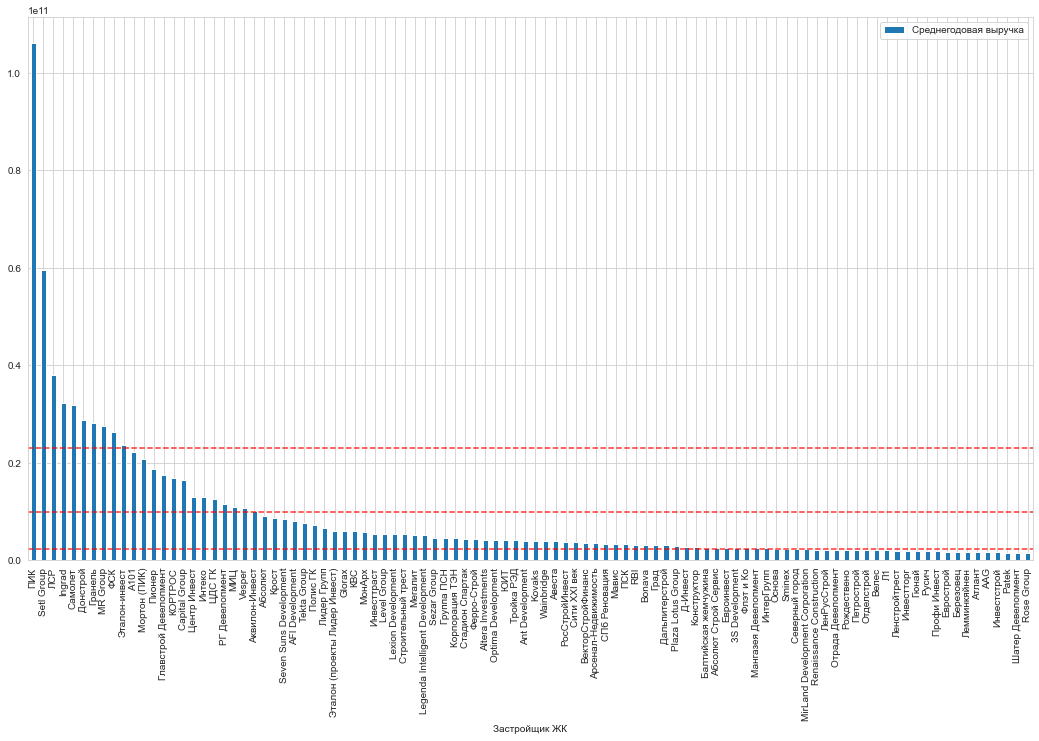

In [176]:
# Визуализуем данные для первых 100:
rev_average.head(100).plot.bar(y='Среднегодовая выручка', x='Застройщик ЖК',  figsize=(18, 10))
# revenue_dev.sort_values('Оценка цены', ascending = False)['Оценка цены'].head(50).plot.bar(y='Оценка выручки', x='Застройщик ЖК',  figsize=(18, 10))
plt.axhline(23000000000, color = 'red', alpha=0.8, linestyle = 'dashed')
plt.axhline(10000000000, color = 'red', alpha=0.8, linestyle = 'dashed')
plt.axhline(2400000000, color = 'red', alpha=0.8, linestyle = 'dashed')
plt.show()

In [177]:
# Основные статистики для показателя среднегодовой выручки:
rev_average.describe()

,Среднегодовая выручка
count,416.0
mean,2380478516.3
std,7625315031.8
min,4404114.0
25%,114661964.1
50%,370535143.5
75%,1435621311.6
max,106212743649.0


In [178]:
# Добавим категории застройщиков, ориентируясь на статистики распределения и визуализацию выше:
rev_grades = ['low', 'lower-middle', 'middle', 'upper-middle', 'high'] 
rev_bins = [0, 370000000, 2400000000, 10000000000, 23000000000, 110000000000] 
# rev_grades = ['low', 'middle', 'high'] 
# rev_bins = [0, 2379000000, 23300000000, 110000000000] 
rev_average['Категория застройщика'] = pd.cut(rev_average['Среднегодовая выручка'], bins = rev_bins, labels = rev_grades)
rev_average['Категория застройщика'].value_counts()
# rev_average.head(15)

low             208
lower-middle    132
middle           53
upper-middle     13
high             10
Name: Категория застройщика, dtype: int64

In [179]:
dev_group = rev_average[['Застройщик ЖК','Категория застройщика']]
dev_group.head()

,Застройщик ЖК,Категория застройщика
260,ПИК,high
54,Setl Group,high
206,ЛСР,high
22,Ingrad,high
323,Самолет,high


In [180]:
db_j2 = db_j1.merge(dev_group, on='Застройщик ЖК', how='left')
# db_j2.shape # >> (286240, 27)

#### Данные ЕРЗ

In [181]:
# Воспользуемся данными портала «Единый ресурс застройщиков» (ЕРЗ.РФ) по ЖК и застройщикам:
# Рейтинг ЕРЗ - показатель соблюдения застройщиком декларируемого срока ввода жилья
# Что такое рейтинг ЕРЗ и как он рассчитывается:  https://erzrf.ru/news/chto-takoye-reyting-yerz-i-kak-on-rasschityvayetsya
# Оценка ЕРЗ - оценка потребительских качеств ЖК на основе 100+ показателей:
# # транспортная доступность
# # парковка
# # социальная инфраструктура
# # объекты спорта
# # дворовые пространства, безопасность
# # и т.д.

In [186]:
# Списки ЕРЗ по регионам:
listRC_Msk = pd.read_excel('Msk_TOP_GK_EXCEL_2021-03-03T15-29-47.xlsx')
listRC_Spb = pd.read_excel('Spb_TOP_GK_EXCEL_2021-03-03T15-31-22.xlsx')
listRC_MO = pd.read_excel('MO_TOP_GK_EXCEL_2021-03-03T15-29-57.xlsx')
listRC_LO = pd.read_excel('LO_TOP_GK_EXCEL_2021-03-03T15-29-37.xlsx')

In [187]:
# Объединим в одну таблицу:
listRC = pd.concat([listRC_Msk, listRC_Spb, listRC_MO, listRC_LO], ignore_index = True).\
            rename(columns={'Оценка ЕРЗ': 'Оценка ЕРЗ ЖК', 'Рейтинг ЕРЗ': 'Рейтинг ЕРЗ застройщика'})
listRC.shape[0] # >> 2260

2260

In [188]:
listRC.head()

,№,ID ЖК,Место Регион / РФ,Наименование ЖК,Регион,Адрес ЖК,Оценка ЕРЗ ЖК,Квартир в продаже,Класс,Этажность,Застройщик,Рейтинг ЕРЗ застройщика
0,1,2965118001,1/,ЖК ЗИЛАРТ,г.Москва,"г.Москва, округ Южный, р-н Даниловский, ул.Авт...",116.0,2503,бизнес,многоэтажные дома,Группа ЛСР,5.0
1,2,3729543001,2/,ЖК Green park,г.Москва,"г.Москва, округ Северо-Восточный, р-н Останкин...",114.0,379,комфорт,дома повышенной этажности,ПИК,4.0
2,3,6064132001,3/,ЖК Селигер Сити,г.Москва,"г.Москва, округ Северный, р-н Западное Дегунин...",109.0,263,комфорт,высотные дома,MR Group,3.5
3,4,6310719001,4/,ЖК Резиденции архитекторов,г.Москва,"г.Москва, округ Центральный, р-н Басманный, ул...",107.0,116,бизнес,многоэтажные дома,AFI Development,4.5
4,5,766001001,5/,ЖК Life-Ботанический cад,г.Москва,"г.Москва, округ Северо-Восточный, р-н Свиблово...",105.0,161,бизнес,дома повышенной этажности,ГК Пионер,4.0


In [189]:
# Общее кол-во пропущенных значений по столбцам:
check_missing_value(listRC)
# missing_values = listRC.isnull().sum()
# missing_values[missing_values > 0]

Оценка ЕРЗ ЖК: 1204 (53%)
Застройщик: 6 (0%)
Рейтинг ЕРЗ застройщика: 4 (0%)
Кол-во полей с пропусками значений: 3


In [190]:
# Список застройщиков в данных Росреестра:
# developers = pd.DataFrame({'Застройщик ЖК': db['Застройщик ЖК'].unique()}).sort_values('Застройщик ЖК')

# # developers.shape # >> (408, 1)
# # developers.head()
# developers.to_excel('developers_rosreestr.xlsx')

In [191]:
# Список застройщиков, по которым есть значения рейтинга ЕРЗ:
RatingERZ_DEV = pd.read_excel('RatingERZ_DEV.xlsx')
RatingERZ_DEV.head()
# RatingERZ_DEV.shape[0] # >> 192

,Наименование застройщика,Рейтинг застройщика ЕРЗ
0,84 высота,0.5
1,AAG,2.0
2,AFI Development,4.5
3,Barkli,0.5
4,Bonava,1.5


In [192]:
# Список ЖК, по которым есть оценка ЕРЗ:
RatingERZ_RC = pd.read_excel('RatingERZ_RC.xlsx')
RatingERZ_RC.head()
# RatingERZ_RC.shape[0] # >> 732

,Наименование ЖК,Оценка ЕРЗ ЖК
0,31-й квартал (Пушкино),69
1,7 Парк,68
2,Аалто,44
3,Авеню Апарт на Дыбенко,10
4,Авеню Апарт на Малом,35


In [417]:
# db_j3.head()

In [193]:
# Добавим эти данные ЕРЗ в датасет:
db_j3 = db_j2.merge(RatingERZ_DEV, how='left', left_on='Застройщик ЖК', right_on='Наименование застройщика')
# db_j4.shape # >> (286240, 30)

In [194]:
db_j4 = db_j3.merge(RatingERZ_RC, how='left', left_on='ЖК рус', right_on='Наименование ЖК')
# db_j5.shape # >> (286240, 33)

In [195]:
db_j4.head()

,ЖК рус,Регион,Округ Направление,Район Город,АТД,Застройщик ЖК,Площадь,Кол-во комнат,Этаж,Тип помещения,Оценка цены,Залогодержатель,Обременения,Уступка,класс,lat,lng,Зона,Тип сделки,Тип оценки,is_buyer_ul,Год,Месяц,Год Месяц,Дней с начала года,Оценка цены 1 кв.м,"Ипотечная ставка, %",Категория застройщика,Наименование застройщика,Рейтинг застройщика ЕРЗ,Наименование ЖК,Оценка ЕРЗ ЖК
0,Мурино парк,Ленинградская область,Всеволожский р-н,Мурино (г.),Всеволожский р-н,Запстрой,20.3,0.0,8,квартира,1567525.0,NaN,отсутствуют,1,эконом,60.1,30.4,4) СПБ - ЛО,ФФ,Оценка по среднему,0,2019,7,2019-07,192.0,77218.0,9.8,lower-middle,Запстрой,2.0,Мурино парк,46.0
1,Румянцево Парк,Новая Москва,НАО,Московский,НАО,Lexion Development,84.8,3.0,10,квартира,9445100.0,РОССЕЛЬХОЗБАНК,ипотека,0,бизнес,55.6,37.4,5) Н. Москва ближ.,ЗФ,Оценка по номеру,0,2020,3,2020-03,75.0,111380.9,7.8,middle,NaN,NaN,Румянцево Парк,62.0
2,Афродита-2,Московская область,Ярославское ш.,Пироговский (бывш. п.г.т.),Мытищи гор.округ,Березовец,26.5,0.0,2,квартира,1961795.0,NaN,отсутствуют,0,комфорт,56.0,37.7,8) МО ср.,ЗФ,Оценка по среднему,0,2019,10,2019-10,281.0,74030.0,9.1,lower-middle,Березовец,0.5,Афродита-2,41.0
3,Полюстрово Парк,Санкт-Петербург,Калининский р-н,МО Пискаревка,Калининский р-н,Setl Group,35.6,1.0,13,квартира,4314150.0,БАНК САНКТ-ПЕТЕРБУРГ,ипотека,1,эконом,60.0,30.4,2) СПБ - КАД,ФФ,Оценка по среднему,0,2019,2,2019-02,34.0,121184.0,9.7,high,Setl Group,5.0,NaN,NaN
4,Виктори Плаза,Санкт-Петербург,Московский р-н,МО Звездное,Московский р-н,Setl Group,154.2,4.0,3,квартира,39135960.0,NaN,отсутствуют,1,премиум,59.9,30.3,2) СПБ - КАД,ФЮ,Оценка по среднему,1,2019,4,2019-04,108.0,253800.0,10.1,high,Setl Group,5.0,Виктори Плаза,84.0


In [421]:
# Добавим переменную наличия обременений:
# db_j5['Наличие обременений'] =  db_j5['Обременения'].apply(lambda x: 0 if x == 'отсутствуют' else 1)

In [196]:
# Отсутствующие значения по оценкам ЖК и рейтингам застройщиков заменим на 0:
db_j4['Рейтинг застройщика ЕРЗ'].fillna(0, inplace = True)
db_j4['Оценка ЕРЗ ЖК'].fillna(0, inplace = True)

In [197]:
# Удалим лишние столбцы:
db_ = db_j4.drop(['Наименование застройщика', 'Наименование ЖК'], axis = 1)

In [198]:
check_missing_value(db_)
# missing_values = db_.isnull().sum()
# missing_values[missing_values > 0]

Залогодержатель: 140296 (48%)
Кол-во полей с пропусками значений: 1


#### Целевой признак: стоимость 1 кв. м

In [214]:
# Для количественных переменных:
db_num = db_.select_dtypes(include=np.number)
# db_num.head()

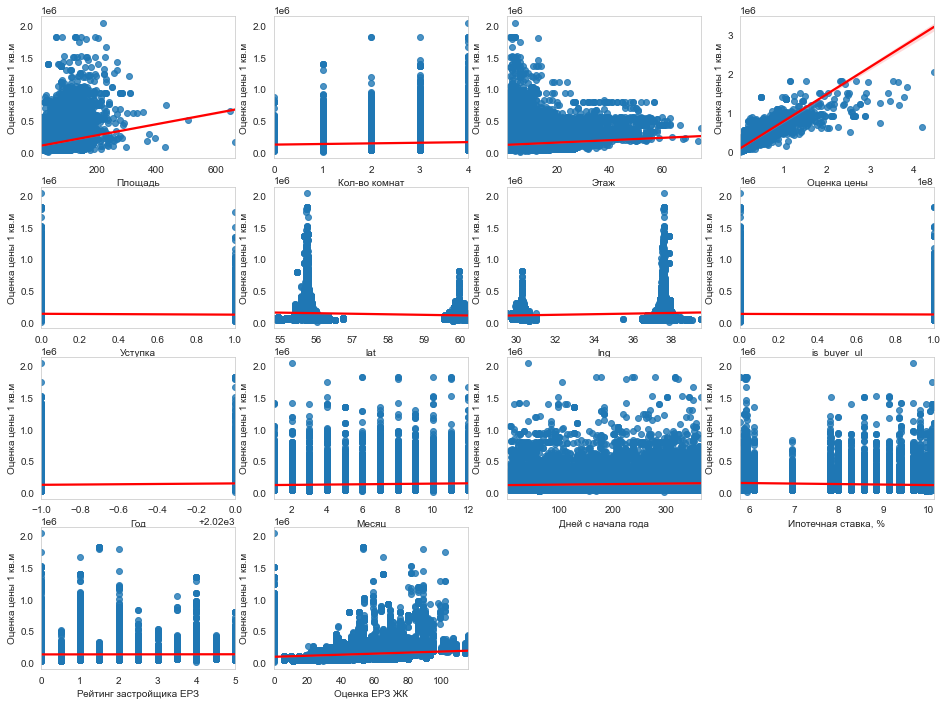

In [200]:
# Визуализируем взаимосвязи (возможные корреляции) целевого признака с остальными:
# Самая выраженная взаимосвязь - с площадью помещения (не считая оценки цены), менее выраженная - с этажом, оценкой ЖК (ЕРЗ)

plt.figure(figsize=(16, 12))
for i, col in enumerate(db_num.loc[:, db_num.columns != 'Оценка цены 1 кв.м']):
    plt.subplot(4, 4, i + 1)
    sns.regplot(x= db_num[col], y=db_num['Оценка цены 1 кв.м'], data=db_num, fit_reg=True,
                line_kws={'color': 'red'}) # fit_reg - строит линию регрессии 
#                scatter_kws={'color': 'blue'}, line_kws={'color': 'red'}) 
    plt.grid(False)
#     plt.show()

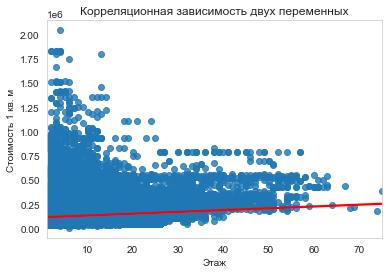

In [201]:
sq = db_['Этаж']
co = db_['Оценка цены 1 кв.м']
sns.regplot(x = sq, y = co, data = db_, fit_reg=True, line_kws={'color': 'red'}) # fit_reg - строит линию регрессии
plt.xlabel('Этаж')
plt.ylabel('Стоимость 1 кв. м')
plt.title('Корреляционная зависимость двух переменных')
plt.grid(False)
plt.show()

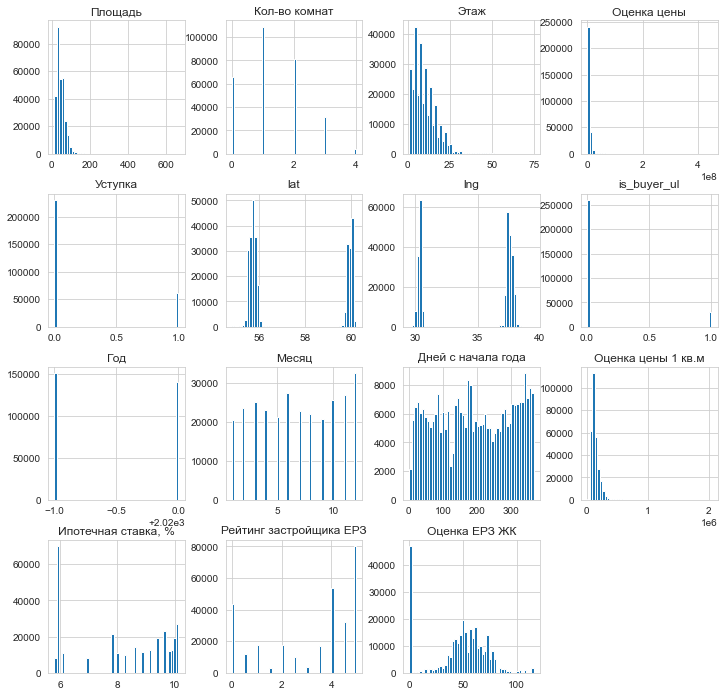

In [202]:
# Для того, чтобы оценить эту взаимосвязь количественно, посмотрим распределение переменных:
db_num.hist(figsize=(12, 12), bins=50)
plt.show()

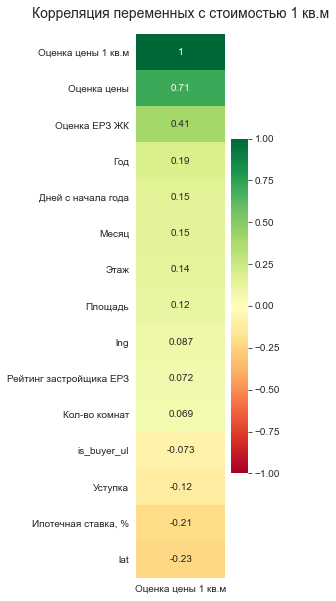

In [203]:
# Во всех случаях оно отличается от нормального, поэтому в расчетах используем коэфф. Спирмена:
plt.figure(figsize=(2, 10))
heatmap = sns.heatmap(db_.corr(method='spearman')[['Оценка цены 1 кв.м']].sort_values(by='Оценка цены 1 кв.м', ascending=False), vmin=-1, vmax=1, annot=True, cmap='RdYlGn')
heatmap.set_title('Корреляция переменных с стоимостью 1 кв.м', fontdict={'fontsize':14}, pad=16)
plt.show()

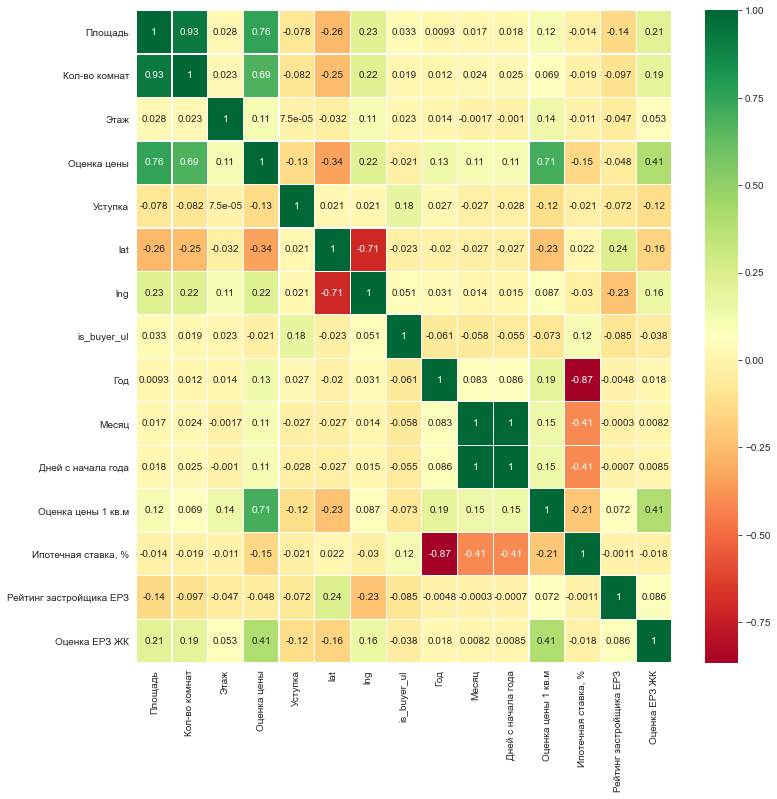

In [204]:
# Максимально коррелирующие с ценой 1 кв. м переменные:
# Оценка ЕРЗ ЖК (коэфф. коррелляции 0.4) - чем выше оцениваются потребительские качества ЖК, тем выше стоимость 1 кв.м
# Широта (-0.23) - в Москве (lat = 55) стоимость выше, чем в С.-Петербурге (lat = 59.57)
# Ставка по ипотеке для первичного рынка (-0.21) - меньшим значениям ставки соответствует большее значение стоимости 1 кв. м 
# Год (0.19) - в 2020 г. стоимость 1 кв. м выше, чем в 2019 г.

# Остальные:
# Месяц, кол-во дней с начала года (0.15)
# Этаж (0.14)
# Площадь (0.12)

sns.heatmap(db_.corr(method='spearman'),annot=True,cmap='RdYlGn', linewidths=0.2) #.corr()--> коэфф. Пирсона по умолчанию
fig=plt.gcf() # gcf() - получение текущей фигуры
fig.set_size_inches(12,12) # set_size_inches() - установить размер фигуры
plt.show()

In [205]:
# Решаем задачу множественной регрессии:
db_.head()
# db_.columns

,ЖК рус,Регион,Округ Направление,Район Город,АТД,Застройщик ЖК,Площадь,Кол-во комнат,Этаж,Тип помещения,Оценка цены,Залогодержатель,Обременения,Уступка,класс,lat,lng,Зона,Тип сделки,Тип оценки,is_buyer_ul,Год,Месяц,Год Месяц,Дней с начала года,Оценка цены 1 кв.м,"Ипотечная ставка, %",Категория застройщика,Рейтинг застройщика ЕРЗ,Оценка ЕРЗ ЖК
0,Мурино парк,Ленинградская область,Всеволожский р-н,Мурино (г.),Всеволожский р-н,Запстрой,20.3,0.0,8,квартира,1567525.0,NaN,отсутствуют,1,эконом,60.1,30.4,4) СПБ - ЛО,ФФ,Оценка по среднему,0,2019,7,2019-07,192.0,77218.0,9.8,lower-middle,2.0,46.0
1,Румянцево Парк,Новая Москва,НАО,Московский,НАО,Lexion Development,84.8,3.0,10,квартира,9445100.0,РОССЕЛЬХОЗБАНК,ипотека,0,бизнес,55.6,37.4,5) Н. Москва ближ.,ЗФ,Оценка по номеру,0,2020,3,2020-03,75.0,111380.9,7.8,middle,0.0,62.0
2,Афродита-2,Московская область,Ярославское ш.,Пироговский (бывш. п.г.т.),Мытищи гор.округ,Березовец,26.5,0.0,2,квартира,1961795.0,NaN,отсутствуют,0,комфорт,56.0,37.7,8) МО ср.,ЗФ,Оценка по среднему,0,2019,10,2019-10,281.0,74030.0,9.1,lower-middle,0.5,41.0
3,Полюстрово Парк,Санкт-Петербург,Калининский р-н,МО Пискаревка,Калининский р-н,Setl Group,35.6,1.0,13,квартира,4314150.0,БАНК САНКТ-ПЕТЕРБУРГ,ипотека,1,эконом,60.0,30.4,2) СПБ - КАД,ФФ,Оценка по среднему,0,2019,2,2019-02,34.0,121184.0,9.7,high,5.0,0.0
4,Виктори Плаза,Санкт-Петербург,Московский р-н,МО Звездное,Московский р-н,Setl Group,154.2,4.0,3,квартира,39135960.0,NaN,отсутствуют,1,премиум,59.9,30.3,2) СПБ - КАД,ФЮ,Оценка по среднему,1,2019,4,2019-04,108.0,253800.0,10.1,high,5.0,84.0


In [216]:
# db_.dtypes
# Кол-во уникальных значений по столбцам с категориальными переменными 
unique_counts = pd.DataFrame.from_records([(col, db_[col].nunique()) for col in db_.select_dtypes(include=['object','category']).columns],
                                          columns=['Column_Name', 'Num_Unique']).sort_values(by=['Num_Unique'])
unique_counts

# db_.select_dtypes(include='object').columns

,Column_Name,Num_Unique
6,Тип помещения,2
12,Тип оценки,3
8,Обременения,4
1,Регион,5
14,Категория застройщика,5
9,класс,6
10,Зона,13
11,Тип сделки,15
13,Год Месяц,24
2,Округ Направление,50


In [426]:
# Оставляем необходимые столбцы:
dbf = db_[['Регион', 'Район Город', 'АТД', 'Зона', 'Площадь', 'Кол-во комнат', 'Этаж', 'Тип помещения', 
                 'Обременения', 'Уступка', 'класс', 'lat', 'lng', 'is_buyer_ul', 
                 'Тип сделки', 'Тип оценки', 'Год', 'Месяц', 'Дней с начала года', 'Ипотечная ставка, %', 
                 'Категория застройщика', 'Рейтинг застройщика ЕРЗ', 'Оценка ЕРЗ ЖК', 'Оценка цены 1 кв.м']]

In [433]:
# dbf.select_dtypes(['object', 'category']).columns

In [427]:
# Преобразуем категориальные переменные в числовые:
db_dummies = pd.get_dummies(dbf, dbf.select_dtypes(['object', 'category']).columns)
# # db_dummies.head()
# db_dummies.shape # >> (286240, 438)

# db_dummies = pd.get_dummies(data.select_dtypes(include=[object]))
# db1 = pd.concat([data_dummies, data], axis=1)
# # db1.head()
# db1.shape

In [435]:
# db_dummies

In [428]:
# Подготовим данные - разделяем признаки и целевую переменную:
# X, y = db_dummies.drop('Оценка цены 1 кв.м', axis=1).values, db_dummies['Оценка цены 1 кв.м'].values # np-матрицы
# X, y = db_dummies.loc[:, db_dummies.columns != 'Оценка цены 1 кв.м'].values, db_dummies['Оценка цены 1 кв.м'].values
X, y = db_dummies.loc[:, db_dummies.columns != 'Оценка цены 1 кв.м'], db_dummies['Оценка цены 1 кв.м']

In [429]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
# train_part_size = int(0.8 * X.shape[0]) # размер обучающей выборки
# X_train, X_test = X[:train_part_size, :], X[train_part_size:, :] # обучающая и отложенная части
# y_train, y_test = y[:train_part_size], y[train_part_size:]

In [430]:
# Масштабируем данные:
scaler = StandardScaler() # при обучении этот объект посчитает среднее и станд. отклонение по каждому признаку (обучится)
X_train_scaled = scaler.fit_transform(X_train) # масштабированная обучающая выборка (fit - обучение scaler, transform - возвращение масштабированной выборки)
X_test_scaled = scaler.transform(X_test) # масштабированная отложенная выборка (масштабирование с помощью посчитанных средних и станд. отклонений)

In [439]:
# X_train_scaled.mean(axis = 0)
# X_train_scaled.std(axis = 0)

#### LinearRegression

In [431]:
# LinearRegression
model = LinearRegression()

In [432]:
# Обучение модели на масштабированных данных:
model.fit(X_train_scaled, y_train)

LinearRegression()

In [433]:
# Формируем прогноз:
y_pred = model.predict(X_test_scaled)

In [434]:
# Стандартное отклонение (среднеквадратическая ошибка) между ответами на отложенной выборке и прогнозами на масштабированной отложенной выборке
# Насколько мы ошибаемся в предсказании Оценки стоимости 1 кв. м, рублей
# Соответственно, если сравнить RMSE со средней стоимостью 1 кв.м, получим среднюю ошибку в процентах
print('RMSE=%.2f' % mean_squared_error(y_test, y_pred, squared=False))

RMSE=44286725755025.30


In [435]:
# Коэффициент детерминации (какой процент наблюдений описывает данная модель?):
# чем ближе значение к 1, тем меньше дисперсия ошибок, по сравнению с дисперсией предсказываемой величины (тем лучше модель)
print('R^2 score=%.2f' % r2_score(y_test, y_pred))

R^2 score=-385561312849741824.00


In [436]:
# Средняя абсолютная погрешность регрессии (прогноза):
print('MAE=%.2f' % mean_absolute_error(y_test, y_pred))

MAE=183547595117.67


In [437]:
# Коэффициенты модели:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(pd.DataFrame(model.coef_, db_dummies.drop('Оценка цены 1 кв.м', axis=1).columns, 
                         columns=['coef']).sort_values(by='coef', ascending=False)) 

,coef
АТД_Ломоносовский р-н,41944327997715232.0
АТД_САО,40482369063663944.0
Район Город_Пущино (г.),38882400512804752.0
Район Город_Серпухов (г.),38695527430454336.0
АТД_СЗАО,34643918450198012.0
Район Город_Жуковский (г.),34458651476257744.0
Район Город_Лобня (г.),33275848537216704.0
АТД_Пушкино гор.округ,33065924633422808.0
АТД_Щелково гор.округ,32299736128175264.0
Район Город_Чехов (г.),29884967401121192.0


In [447]:
# print('intercept:', model.intercept_)
# print('slope:', model.coef_)
# https://proglib.io/p/linear-regression/

#### DecisionTreeRegressor

In [ ]:
model = DecisionTreeRegressor()

In [ ]:
model.fit(X_train_scaled, y_train)

In [ ]:
y_pred = model.predict(X_test_scaled)

In [ ]:
print('RMSE=%.2f' % mean_squared_error(y_test, y_pred, squared=False))
print('R^2 score=%.2f' % r2_score(y_test, y_pred))
print('MAE=%.2f' % mean_absolute_error(y_test, y_pred))

#### 2020 vs. 2019

In [ ]:
# Повторим машинное обучение на двух массивах, соответствующих годам:
db2020 = db_dummies.loc[db_dummies['Год'] == 2020]
db2019 = db_dummies.loc[db_dummies['Год'] == 2019]

In [ ]:
# Удаляем столбец с годом:
db2020 = db2020.drop(['Год'], axis = 1)
db2019 = db2019.drop(['Год'], axis = 1)

In [ ]:
# Создаем модель и считаем коэффициенты для 2020 года:

# Подготовим данные - разделяем признаки и целевую переменную:
# X, y = db2020.loc[:, db2020.columns != 'Оценка цены 1 кв.м'].values, db2020['Оценка цены 1 кв.м'].values
X, y = db2020.loc[:, db2020.columns != 'Оценка цены 1 кв.м'], db2020['Оценка цены 1 кв.м']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
# train_part_size = int(0.8 * X.shape[0]) # размер обучающей выборки
# X_train, X_test = X[:train_part_size, :], X[train_part_size:, :] # обучающая и отложенная части
# y_train, y_test = y[:train_part_size], y[train_part_size:]

In [ ]:
# Масштабируем данные:
scaler = StandardScaler() # при обучении этот объект посчитает среднее и станд. отклонение по каждому признаку (обучится)
X_train_scaled = scaler.fit_transform(X_train) # масштабированная обучающая выборка (fit - обучение scaler, transform - возвращение масштабированной выборки)
X_test_scaled = scaler.transform(X_test) # масштабированная отложенная выборка (масштабирование с помощью посчитанных средних и станд. отклонений)

In [ ]:
# LinearRegression
model = LinearRegression()

In [ ]:
# Обучение модели на масштабированных данных:
model.fit(X_train_scaled, y_train)

In [ ]:
# Формируем прогноз:
y_pred = model.predict(X_test_scaled)

In [ ]:
print('RMSE=%.2f' % mean_squared_error(y_test, y_pred, squared=False))
print('R^2 score=%.2f' % r2_score(y_test, y_pred))
print('MAE=%.2f' % mean_absolute_error(y_test, y_pred))

In [ ]:
# Коэффициенты модели для 2020 года:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(pd.DataFrame(model.coef_, db2020.drop('Оценка цены 1 кв.м', axis=1).columns, 
                         columns=['coef']).sort_values(by='coef', ascending=False)) 

In [ ]:
# Создаем модель и считаем коэффициенты для 2019 года:

# Подготовим данные - разделяем признаки и целевую переменную:
# X, y = db2019.loc[:, db2019.columns != 'Оценка цены 1 кв.м'].values, db2019['Оценка цены 1 кв.м'].values
X, y = db2019.loc[:, db2019.columns != 'Оценка цены 1 кв.м'], db2019['Оценка цены 1 кв.м']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
# train_part_size = int(0.8 * X.shape[0]) # размер обучающей выборки
# X_train, X_test = X[:train_part_size, :], X[train_part_size:, :] # обучающая и отложенная части
# y_train, y_test = y[:train_part_size], y[train_part_size:]

In [ ]:
# Масштабируем данные:
scaler = StandardScaler() # при обучении этот объект посчитает среднее и станд. отклонение по каждому признаку (обучится)
X_train_scaled = scaler.fit_transform(X_train) # масштабированная обучающая выборка (fit - обучение scaler, transform - возвращение масштабированной выборки)
X_test_scaled = scaler.transform(X_test) # масштабированная отложенная выборка (масштабирование с помощью посчитанных средних и станд. отклонений)

In [ ]:
# LinearRegression
model = LinearRegression()

In [ ]:
# Обучение модели на масштабированных данных:
model.fit(X_train_scaled, y_train)

In [ ]:
# Формируем прогноз:
y_pred = model.predict(X_test_scaled)

In [ ]:
print('RMSE=%.2f' % mean_squared_error(y_test, y_pred, squared=False))
print('R^2 score=%.2f' % r2_score(y_test, y_pred))
print('MAE=%.2f' % mean_absolute_error(y_test, y_pred))

In [ ]:
# Коэффициенты модели для 2019 года:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(pd.DataFrame(model.coef_, db2019.drop('Оценка цены 1 кв.м', axis=1).columns, 
                         columns=['coef']).sort_values(by='coef', ascending=False)) 

#### Целевой признак: спрос на помещения

In [ ]:
db = sel[['ЖК рус', 'Регион', 'Район Город', 'АТД', 'Застройщик ЖК', 'Площадь', 'Кол-во комнат', 'Этаж', 
          'Тип помещения', 'Оценка цены', 'Залогодержатель', 'Обременения', 'Уступка', 'класс', 'lat', 'lng', 
          'Зона', 'Тип сделки', 'Тип оценки', 'is_buyer_ul', 'Год', 'Месяц', 'Год Месяц', 'Дней с начала года', 
          'Оценка цены 1 кв.м']]
db.head()

In [ ]:
# db_gr = db.groupby(['Регион', 'Зона', 'Район Город', 'АТД', 'Застройщик ЖК', 'ЖК рус', 'класс', 'Тип помещения', 'Кол-во комнат',
#             'Площадь', 'Этаж', 'Обременения', 'is_buyer_ul', 'Год', 'Дней с начала года', 'Год Месяц', 'Уступка', 'Оценка цены 1 кв.м'])\
#     .agg(['count'])[['Месяц']].reset_index()
# db_gr.shape # >> (284717, 19)

db_gr = db.groupby(['Регион', 'Застройщик ЖК', 'ЖК рус', 'класс', 'Тип помещения', 'Кол-во комнат',
            'Площадь', 'Этаж', 'Обременения', 'is_buyer_ul', 'Год', 'Год Месяц', 'Оценка цены 1 кв.м'])\
    .agg(['count'])[['Месяц']].reset_index()



In [ ]:
db_gr.head()

In [ ]:
# db_gr.columns =['Регион', 'Зона', 'Район Город', 'АТД', 'Застройщик ЖК', 'ЖК рус', 'класс', 'Тип помещения', 'Кол-во комнат',
#             'Площадь', 'Этаж', 'Обременения', 'is_buyer_ul', 'Год', 'Дней с начала года', 'Год Месяц', 'Уступка', 'Оценка цены 1 кв.м', 
#              'Кол-во помещений']
# db_gr.head()

db_gr.columns =['Регион', 'Застройщик ЖК', 'ЖК рус', 'класс', 'Тип помещения', 'Кол-во комнат',
            'Площадь', 'Этаж', 'Обременения', 'is_buyer_ul', 'Год', 'Год Месяц', 'Оценка цены 1 кв.м', 
             'Кол-во помещений']

In [ ]:
db_j1 = db_gr.merge(mr, on='Год Месяц', how='left')

In [ ]:
# db_j1.head()
# db_j1.shape # >> (284717, 20)

In [ ]:
db_j2 = db_j1.merge(dev_group, on='Застройщик ЖК', how='left')
# db_j2.shape # >> (284717, 21)

In [ ]:
# Добавим эти данные ЕРЗ в датасет:
db_j3 = db_j2.merge(RatingERZ_DEV, how='left', left_on='Застройщик ЖК', right_on='Наименование застройщика')
# db_j3.shape # >> (284717, 23)

db_j4 = db_j3.merge(RatingERZ_RC, how='left', left_on='ЖК рус', right_on='Наименование ЖК')
# db_j4.shape # >> (284717, 25)

In [ ]:
# Отсутствующие значения по оценкам ЖК и рейтингам застройщиков заменим на 0:
db_j4['Рейтинг застройщика ЕРЗ'].fillna(0, inplace = True)
db_j4['Оценка ЕРЗ ЖК'].fillna(0, inplace = True)

# Удалим лишние столбцы:
demand = db_j4.drop(['Наименование застройщика', 'Наименование ЖК'], axis = 1)

In [ ]:
check_missing_value(demand)

In [ ]:
# demand.shape # >> (284717, 23)
# demand.head()
# demand[demand['Кол-во помещений'] > 1]
# demand.describe()

In [ ]:
# Для количественных переменных:
demand_num = demand.select_dtypes(include=np.number)
demand_num.head()

In [ ]:
# Визуализируем взаимосвязи (возможные корреляции) целевого признака с остальными:
# Они, скорее, отсутствуют.
plt.figure(figsize=(16, 12))
for i, col in enumerate(demand_num.loc[:, demand_num.columns != 'Кол-во помещений']):
    plt.subplot(4, 3, i + 1)
    sns.regplot(x= demand_num[col], y=demand_num['Кол-во помещений'], data=demand_num, fit_reg=True,
                line_kws={'color': 'red'}) # fit_reg - строит линию регрессии 
#                scatter_kws={'color': 'blue'}, line_kws={'color': 'red'}) 
    plt.grid(False)
#     plt.show()

In [ ]:
# Для того, чтобы оценить взаимосвязь количественно, посмотрим распределение переменных:
demand_num.hist(figsize=(12, 12), bins=50)
# dbn.hist(bins=30, figsize=(12, 12))
plt.show()

In [ ]:
# Во всех случаях оно отличается от нормального, поэтому в расчетах используем коэфф. Спирмена:
plt.figure(figsize=(2, 10))
heatmap = sns.heatmap(demand.corr(method='spearman')[['Кол-во помещений']].sort_values(by='Кол-во помещений', ascending=False), vmin=-1, vmax=1, annot=True, cmap='RdYlGn')
heatmap.set_title('Корреляция переменных с целевой', fontdict={'fontsize':14}, pad=16)
plt.show()

In [ ]:
# Максимально коррелирующие со спросом переменные:
# Тип покупателя (коэфф. корреляции 0.2) 

sns.heatmap(demand.corr(method='spearman'),annot=True,cmap='RdYlGn', linewidths=0.2) #.corr()--> коэфф. Пирсона по умолчанию
fig=plt.gcf() # gcf() - получение текущей фигуры
fig.set_size_inches(12,12) # set_size_inches() - установить размер фигуры
plt.show()

In [ ]:
# Решаем задачу множественной регрессии:
# demand.head()
# demand.columns

In [ ]:
# Оставляем необходимые столбцы:
# demandf = demand[['Регион', 'Район Город', 'АТД', 'Зона', 'Площадь', 'Кол-во комнат', 'Этаж', 'Тип помещения', 
#                  'Обременения', 'класс', 'is_buyer_ul', 'Год', 'Дней с начала года', 'Ипотечная ставка, %',
#                   'Оценка цены 1 кв.м', 'Категория застройщика', 'Рейтинг застройщика ЕРЗ', 'Оценка ЕРЗ ЖК', 
#                   'Кол-во помещений']]


demandf = demand[['Регион', 'Площадь', 'Кол-во комнат', 'Этаж', 'Тип помещения', 
                 'Обременения', 'класс', 'is_buyer_ul', 'Год', 'Ипотечная ставка, %',
                  'Оценка цены 1 кв.м', 'Категория застройщика', 'Рейтинг застройщика ЕРЗ', 'Оценка ЕРЗ ЖК', 
                  'Кол-во помещений']]

In [ ]:
# Преобразуем категориальные переменные в числовые:
demandf_dummies = pd.get_dummies(demandf, demandf.select_dtypes(['object', 'category']).columns)
# demandf_dummies.head()
# demandf_dummies.shape # >> (284681, 421)

In [ ]:
# Подготовим данные - разделяем признаки и целевую переменную:
# X, y = demandf_dummies.loc[:, demandf_dummies.columns != 'Кол-во помещений'].values, demandf_dummies['Кол-во помещений'].values
X, y = demandf_dummies.loc[:, demandf_dummies.columns != 'Кол-во помещений'], demandf_dummies['Кол-во помещений']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
# train_part_size = int(0.8 * X.shape[0]) # размер обучающей выборки
# X_train, X_test = X[:train_part_size, :], X[train_part_size:, :] # обучающая и отложенная части
# y_train, y_test = y[:train_part_size], y[train_part_size:]

In [ ]:
# Масштабируем данные:
scaler = StandardScaler() # при обучении этот объект посчитает среднее и станд. отклонение по каждому признаку (обучится)
X_train_scaled = scaler.fit_transform(X_train) # масштабированная обучающая выборка (fit - обучение scaler, transform - возвращение масштабированной выборки)
X_test_scaled = scaler.transform(X_test) # масштабированная отложенная выборка (масштабирование с помощью посчитанных средних и станд. отклонений)

In [ ]:
# X_train_scaled.mean(axis = 0)
# X_train_scaled.std(axis = 0)

#### LinearRegression

In [ ]:
# LinearRegression
model = LinearRegression()

In [ ]:
# Обучение модели на масштабированных данных:
model.fit(X_train_scaled, y_train)

In [ ]:
# Формируем прогноз:
y_pred = model.predict(X_test_scaled)

In [ ]:
print('RMSE=%.2f' % mean_squared_error(y_test, y_pred, squared=False))
print('R^2 score=%.2f' % r2_score(y_test, y_pred))
print('MAE=%.2f' % mean_absolute_error(y_test, y_pred))

In [ ]:
# Коэффициенты модели:
# with pd.option_context('display.max_rows', None, 'display.max_columns', None):
#     display(pd.DataFrame(model.coef_, demandf_dummies.drop('Оценка цены 1 кв.м', axis=1).columns, 
#                          columns=['coef']).sort_values(by='coef', ascending=False)) 

#### DecisionTreeRegressor

In [ ]:
model = DecisionTreeRegressor()

In [ ]:
model.fit(X_train_scaled, y_train)

In [ ]:
y_pred = model.predict(X_test_scaled)

In [ ]:
print('RMSE=%.2f' % mean_squared_error(y_test, y_pred, squared=False))
print('R^2 score=%.2f' % r2_score(y_test, y_pred))
print('MAE=%.2f' % mean_absolute_error(y_test, y_pred))